# Evolutive Linear Regression

Linear model is a powerfull tool but much of its power comes from its semplicity that requires a lot of fine-tuning in the model specification. It's possible to setup the problem of finding a good model as an optimization one. The objective to optimize needs to include a measure of the model's performance and a measure of the likelihood that its assumptions are correct. Than its possible to rewrite the problem as "not lnear integer programming" and use a multiobjective optimization algorithm to solve it.

## The Linear Model

The linear model can be writen as 
$$
Y_i = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \dots + \beta_k X_{ki} + u_i
$$
In matrix form it becomes
$$
Y = X \beta + u
$$
Given some data we can estimate the paramters vector $ \beta $ through the OLS criterion
$$
b = (X^TX)^{-1}(X^TY)
$$

In [134]:
# We define a model with a method to predict and one to fit on the data

import numpy as np

class Model():
    def __init__(self):
        super().__init__()
        self.b = None

    def predict(self, _X):
        X = np.c_[np.ones(_X.shape[0]), _X] # adding the ones column
        return np.matmul(X, self.b)

    def fit(self, _X, Y):
        X = np.c_[np.ones(_X.shape[0]), _X]
        self.b = np.matmul(np.linalg.inv(np.matmul(X.transpose(), X)), np.matmul(X.transpose(), Y))

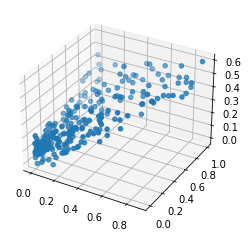

In [135]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt

# Lets try a simple example with just two regressors

X = np.random.rand(256, 2) # random matrix (256 x 2) with random values between 0 and 1

model = Model()
model.b = np.array([0.1, 0.2, 0.3]) # defining the model's parameters
 # some non linear transformation
X[:, 0] = X[:, 0] * X[:, 1] # X_0 = X_0 * X_1
X[:, 1] = X[:, 1]**2 # X_1 = (X_1)^2

Y = model.predict(X) # the target variable
Y += np.random.randn(Y.shape[0]) * 0.05 # adding gaussian noise

# plotting the result
ax = plt.axes(projection="3d")
ax.scatter3D(X[:, 0], X[:, 1], Y)

beta = [0.1 0.2 0.3]
b    = [0.10560361 0.19989886 0.28083733]


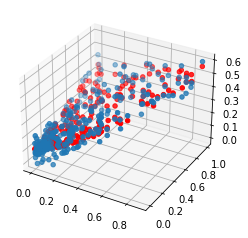

In [136]:
# Now we estimate the parameters model

est_model = Model()
est_model.fit(X, Y)

Y_hat = est_model.predict(X)

# plotting the result
ax = plt.axes(projection="3d")
ax.scatter3D(X[:, 0], X[:, 1], Y)
ax.scatter3D(X[:, 0], X[:, 1], Y_hat, color="red")


print(f"beta = {model.b}")
print(f"b    = {est_model.b}")

The model is used to predict $ \hat{Y} $, the difference between $ Y, \hat{Y} $ are the **residuals** 
$$
\vec{e} = Y - \hat{Y}
$$
Residuals are usefull for analysing our model end estimating its performances. The residuals sum of squares **RSS** is
$$
RSS = e^Te = \sum e_i^2 
$$
and it's used to calculate the **Adjusted $ R^2 $** which measures the portion of variability of **Y** explained by the model and add some penalites for the number of regressors:
$$
\bar{R^2} = 1 - \frac{RSS}{TSS} \times \frac{n-1}{n-k}\\
$$

In [137]:
# A function to compute R_squared

def adjusted_R_squared(rss, tss, n, k):
    return 1 - (rss/tss) * ((n-1)/(n-k))

For the OLS estimator to be **BLUE** *(Best Linear Unbiased Estimator)* some assumptions on the residuals must hold true, this assumptions are:
- $ E[u|X] = 0 $
- $ (X_1, X_2, \dots , X_k) \sim i.i.d $
- $ X_1, X_2, \dots , X_k, u $ have 4 finite moments
- X has no perfect multicollinearity
- $ u_i \sim iid \; N(0, \sigma^2), \; \forall i $  

The **p-value** of one or more statistical test can be used to account for the assumptions in the optimization problem. In this example only the Shapiro-Wilk test is used to test for the Normality of the residuals, the null-hypothesis is that the data come from a Normal distribution.

In [138]:
# The function return the p-value of the Shapiro-Wilk test

from scipy import stats

def shapiro_wilk_pvalue(res):
    shapiro_test = stats.shapiro(res)
    return shapiro_test.pvalue

In [139]:
# Now we update our class Model to calculate these statistics

class Model():
    def __init__(self):
        super().__init__()
        self.b = None

    def predict(self, _X):
        X = np.c_[np.ones(_X.shape[0]), _X] # adding the ones column
        return np.matmul(X, self.b)

    def fit(self, _X, Y):
        X = np.c_[np.ones(_X.shape[0]), _X]
        self.b = np.matmul(np.linalg.inv(np.matmul(X.transpose(), X)), np.matmul(X.transpose(), Y))
        # evaluating the model
        Y_hat = self.predict(_X)
        res = Y - Y_hat
        rss = res.var()
        tss = Y.var()
        n, k = X.shape
        R_squared = adjusted_R_squared(rss, tss, n, k)
        shapiro_wilk = shapiro_wilk_pvalue(res)
        return {"R_squared": R_squared,
                "shapiro-wilk": shapiro_wilk}

In [140]:
# Now let's estimate the model again and look at the metrics

est_model = Model()
metrics = est_model.fit(X, Y)
print(metrics) 

{'R_squared': 0.8541567486280186, 'shapiro-wilk': 0.9642758369445801}


A real world problem can be formulated as finding the best regressors or a non linear transformation of them from a dataset of many possible regressors. The process of finding the best model can be seen as a search through the model space guided by the metrics discussed above. The problem needs to be formulated in a way easy to optimize with current optimization algorithms in the form of a vector of parameters. It's possible to model the problem as chosing the right combination of regressors and not linear transformation that after been estimated with the OLS criterion returns the best metrics. 

In practice we want to set up the process of finding a good model as a multiobjective optimization problem. We assume that we want to model a certain random variable **Y** and we have some **data** in the form of a matrix *(N x Z)* with **N** samples and **Z** possible regressors.  
The **Adjusted $ R^2 $** it's used as the performance metric while the p-value of the **Shapiro-Wilk Test** on the residulas it's used as a mesure of how well the assumptions hold.  
So we try to find a model that maximize:
- the **Adjusted $ R^2 $**
- the p-value of the **Shapiro-Wilk Test** on the residuals

To solve this problem as an optimization one we need a way to encode a vast set of models in a simple format which would be easier to treat mathematicaly. We econde a model into a series of **genes** where each **gene** represents a possible regressor of the model and has 4 values:
1. *Bool*, To use it or not in the model, (True/False)
2. *Integer*, The id of the regressor's column, (0 <= z < Z)
3. *Integer*, The id of the trasformation to apply to the regressor
4. *Integer*, [Optional] Used to indicate another regressor if the trasformation is $ f(X_i, X_j) $ 

*A model is defined as a sequence of a finite number of genes but not all the genes have to be used in the model.*

A model could be described as a matrix of size (L x 4)
$$
\begin{bmatrix}
    [0.1, 0.9, 0.5, 0.3] \\
    [0.3, 0.3, 0.9, 0.7] \\
    \dots
\end{bmatrix}
$$
The next step is to map a real number between 0 and 1 to an index of a finite array. The arrays could be:
1. [True, False]
2. [0, 1, 2, 3, 4, ..., Z]
3. [x,  x^2,  sqrt(x),  log(x),  exp(x),  x*y]
4. [0, 1, 2, 3, 4, ..., Z]

The idea is to divide the range 0 to 1 into *n* spaces with *n = length(array)* and then given x with (0 <= x < = 1) return the index of the corresponding space.  

We optimize with the **NSGA-II** algorithm which is an evlutionary algorithm that has be proven effective in multiobjective optimization. The algorithm uses the pareto equilibrium to identify a set of pareto efficient frontiers from which it samples the next generation of solution. The result of the optimization is a set of optimal solution which are not dominated by one another, we can then choose the best one for our purpose using domain knowledge or by further statistical analysis.

In [141]:
# The dataset is a matrix of 256 samples and 10 possible regressors

import numpy as np

data = np.random.rand(256, 10)

In [142]:
# Now we define the population model we would like to estimate

model = Model()
model.b = np.array([0.1, 0.2, 0.3])
X[:, 0] = data[:, 0] * data[:, 1]
X[:, 1] = data[:, 1]**2

Y = model.predict(X) 
Y += np.random.randn(Y.shape[0]) * 0.05 

In [143]:
# The trasformations for the regressors

from collections import OrderedDict

regr_trans = OrderedDict()
regr_trans["x"] = lambda x: x
regr_trans["x^2"] = lambda x: x**2
regr_trans["sqrt(x)"] = lambda x: np.sqrt(x)
regr_trans["log(x)"] = lambda x: np.log(x)
regr_trans["e^x"] = lambda x: np.exp(x)
regr_trans["xy"] = lambda x, y: x * y

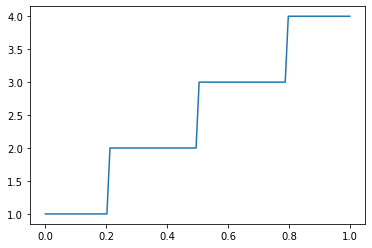

In [144]:
# This function map a real value between 0 and 1 to the index of a finite array

def float_index(i, array):
    array_len = len(array)
    eps = 1 / len(array) / 4
    f_array = np.linspace(0+eps, 1-eps, array_len)
    dists = np.abs(f_array - i)
    if type(array) != OrderedDict:
        return array[np.argmin(dists)]
    return list(array.keys())[np.argmin(dists)]


# plotting an example of how the function works
array = [1, 2, 3, 4]
x = np.linspace(0, 1, 100)
y = [float_index(i, array) for i in x]
plt.plot(x, y)


In [145]:
# Here we define an object that stores the data of possible solutions to the problem

from collections import namedtuple

Solution = namedtuple("Solution", ("regrs", "regrs_2", "trans", "model", "metrics"))


# regrs   -> array of indicies (the columns of the dataset used by the model)
# regrs_2 -> complementary regressors if trans = f(x, y)
# trans   -> array of functions applied to the regressors
# model   -> object Model storing the estimated parameters "b"
# metrics -> the R_squared and shapiro-wilk scores

In [146]:
# The optimization algorithm works with a vectors of real numbers 
# we need a function that generate a solution from the raw vector representation

from inspect import signature

def vec_to_sol(vec, data, Y):
    genes = np.reshape(vec, (-1, 4))
    regrs = []
    regrs_2 = []
    transfs = []
    all_regrs = np.arange(0, data.shape[1])
    for gene in genes:
        to_use = float_index(gene[0], [True, False])
        if to_use:
            regr = float_index(gene[1], all_regrs)
            func = float_index(gene[2], regr_trans)
            regr_2 = -1
            sig = signature(regr_trans[func])
            if len(sig.parameters) == 2:
                regr_2 = float_index(gene[1], np.delete(all_regrs, regr))
            regrs.append(regr)
            regrs_2.append(regr_2)
            transfs.append(func)
    if len(regrs) == 0:
        return None
    _X = np.zeros((data.shape[0], len(regrs)))
    for i, func in enumerate(transfs):
        sig = signature(regr_trans[func])
        if len(sig.parameters) == 1:
            _X[:, i] = regr_trans[func](data[:, regrs[i]])
        else:
            _X[:, i] = regr_trans[func](data[:, regrs[i]], data[:, regrs_2[i]])
    if len(regrs) > 1 and np.linalg.matrix_rank(_X) < _X.shape[1]:
        return None
    model = Model()
    metrics = model.fit(_X, Y)
    return Solution(regrs, regrs_2, transfs, model, metrics)


# a function to print a solution
def print_sol(sol):
    print(f"regrs  : {sol.regrs}")
    print(f"regrs_2: {sol.regrs_2}")
    print(f"trans  : {sol.trans}")
    print(f"params : {sol.model.b}")
    print(f"metrics: {sol.metrics}\n")
        
# Let's try a random raw vector
sol = None
while sol is None:
    raw_vec = np.random.rand(16) # vec of size 16
    sol = vec_to_sol(raw_vec, data, Y)
print_sol(sol)

regrs  : [3, 4]
regrs_2: [-1, -1]
trans  : ['e^x', 'x^2']
params : [ 0.25152379 -0.00471803  0.01678454]
metrics: {'R_squared': -0.006331577622899154, 'shapiro-wilk': 3.6545097827911377e-06}



In [147]:
# The optimization algorithm requires the problem to be formulated 
# as a Problem object that should follows some criteria.


from pymoo.core.problem import ElementwiseProblem

class OptProblem(ElementwiseProblem):
    def __init__(self, data, Y, max_num_regrs):
        super().__init__(n_var=max_num_regrs*4, n_obj=2, n_costr=1, xl=0., xu=1.)
        self.data = data
        self.Y = Y

    def _evaluate(self, x, out, *args, **kwargs):
        sol = vec_to_sol(x, self.data, self.Y)
        if sol is not None:
            out["F"] = [-sol.metrics["R_squared"], -sol.metrics["shapiro-wilk"]]
            out["G"] = 0
        else:
            out["F"] = [1, 1]
            out["G"] = 1

problem = OptProblem(data, Y, 2)

In [148]:
# We setup the algorithm to solve our optimization problem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

algorithm = NSGA2(pop_size=100)
res = minimize(problem,
               algorithm,
               termination=('n_gen', 100),
               verbose=False)

In [149]:
# The algorithm returns a set of not dominated solutions in the form of raw vectors
# We convert them into an array of Solutions

sols = list(map(vec_to_sol, res.X, [data for _ in range(len(res.X))], [Y for _ in range(len(res.X))]))

# For every solution we have a vector with the fitting metrics
metrics = -res.F

In [150]:
# Let's see how well a model fits the data when we use the
# correct combination of regressors and their transformations

true_model = Model()
X = np.zeros((data.shape[0], 2))
X[:, 0] = data[:, 0] * data[:, 1] # xy
X[:, 1] = data[:, 1]**2           # x^2
true_metrics = true_model.fit(X, Y)
true_metrics

{'R_squared': 0.8543874378133995, 'shapiro-wilk': 0.43498870730400085}

In [151]:
# We now search for the solution in our set of optimal solutions
# that has the closest metrics

metrics_dist = np.zeros(len(res.F))
for i, metric in enumerate(metrics):
    dist = np.sqrt((true_metrics["R_squared"] - metric[0])**2 + (true_metrics["shapiro-wilk"] - metric[1])**2)
    metrics_dist[i] = dist

sol = sols[np.argmin(metrics_dist)]
print_sol(sol)

regrs  : [0, 1]
regrs_2: [1, -1]
trans  : ['xy', 'x^2']
params : [0.10271498 0.20482712 0.2906445 ]
metrics: {'R_squared': 0.8543874378133995, 'shapiro-wilk': 0.43498870730400085}



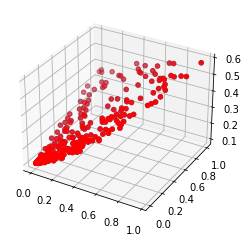

In [152]:
# Let's plot the two models to see how close they are

true_Y_hat = true_model.predict(X)

sol_X = np.zeros((data.shape[0], len(sol.regrs)))
for i, func in enumerate(sol.trans):
    sig = signature(regr_trans[func])
    if len(sig.parameters) == 1:
        sol_X[:, i] = regr_trans[func](data[:, sol.regrs[i]])
    else:
        sol_X[:, i] = regr_trans[func](data[:, sol.regrs[i]], data[:, sol.regrs_2[i]])
sol_Y_hat = sol.model.predict(sol_X)

ax = plt.axes(projection="3d")
ax.scatter3D(X[:, 0], X[:, 1], true_Y_hat)
ax.scatter3D(sol_X[:, 0], sol_X[:, 1], sol_Y_hat, color="red")

In conclusion the algorithm has been able to find the exact combination of regressors and not linear trabsformations used in the population model. The results were actually a set of not dominated results of which the true solution was only one in many others.  
The algorithm can be improved by increasing the number of metrics used to evaluate a solution and customizing the mutation and crossover strategies employed by the evolutionary algorithm.